# Random Subset Sum Problems

This notebook contains code to re-create our plot showing the effect of rounding to certain bit precisions on optimum correctness.

In [15]:
import os

import matplotlib.pyplot as plt
import numpy             as np

from matplotlib.cm       import viridis
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors   import ListedColormap, BoundaryNorm
from qubolite.embedding  import SubsetSum
from qubolite.solving    import brute_force

try:
    from tqdm import trange
except ImportError:
    trange = range

In [16]:
def random_subset_sum(n, rng):
    values = np.abs(np.round(rng.standard_cauchy(size=n) * 10)).astype(int)
    mask_size = int(np.round(rng.triangular(0.2*n, 0.5*n, 0.8*n)))
    indices = rng.permutation(n)[:mask_size]
    target = values[indices].sum()
    return SubsetSum(values, target).qubo

Note that the following code performs an experiment by sampling 100K QUBO instances. Depending on your system, this might take a very long time. To obtain a coarse result in a shorter amount of time, reduce the value of `r` below from `100_000` to a smaller value like `1000`. This will increase the variance and lead to more ragged curves in the final plot.

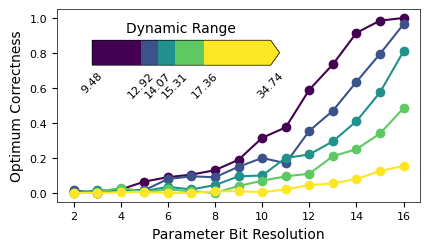

In [17]:
n  = 16               # QUBO dimension
bs = np.arange(2, 17) # bits precisions
r  = 100_000          # total number of QUBO instances to sample
dr_bins = 5           # number of DR bins

result_path = 'RandomSubsetSumByDR.npz'
force = False
if os.path.exists(result_path) and not force:
    f = np.load(result_path)
    drs, result = f['drs'], f['result']
    f.close()
else:
    rng = np.random.default_rng(0x98ab38) # fixed seed for reproduceability
    drs = np.empty(r)
    result = np.empty((r, bs.size))
    for i_r in trange(r):
        Q = random_subset_sum(n, rng)
        drs[i_r] = Q.dynamic_range()
        x, v = brute_force(Q, return_value=True)
        for i_b, b in enumerate(bs):
            Q_ = Q.as_int(b)
            x_ = brute_force(Q_)
            result[i_r, i_b] = np.isclose(Q(x_)-v, 0)
    np.savez_compressed(result_path, drs=drs, result=result)

bin_edges = np.quantile(drs, np.linspace(0, 1, dr_bins+1))
bin_ixs = np.minimum(np.digitize(drs, bins=bin_edges)-1, dr_bins-1)
# ^ include maximum value in rightmost bin

plt.rcParams.update({
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'axes.titlesize': 10,
    'font.size': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})
fig, ax = plt.subplots(figsize=(4.6850, 2.5))
for i, c in zip(range(dr_bins), viridis(np.linspace(0,1,dr_bins))):
    bin_result = result[bin_ixs==i]
    mean = bin_result.mean(0)
    ax.plot(bs, mean, 'o-', color=c, label=fr'DR $\in [{bin_edges[i]:.1f},{bin_edges[i+1]:.1f})$')

ax1 = fig.add_axes((0.2, 0.656, 0.4, 0.1))
cmap = ListedColormap(viridis(np.linspace(0,1,dr_bins)))
cb = ColorbarBase(ax1, cmap=cmap,
        norm=BoundaryNorm(np.r_[bin_edges[:-1], 22], dr_bins),
        extend='max',
        ticks=bin_edges,
        spacing='proportional',
        orientation='horizontal')
cb.ax.tick_params(length=0)
ax1.set_title('Dynamic Range')
ax1.set_xticks(np.r_[bin_edges[:-1], 22], labels=[f'{x:.2f}' for x in bin_edges])
ax1.tick_params(rotation=45)

ax.set_xticks(bs[::2])
ax.set_xlabel('Parameter bit resolution'.title())
ax.set_ylabel('Optimum correctness'.title())

fig.show()